<a href="https://colab.research.google.com/github/dercodeKoenig/hft_dqn/blob/main/hft_dqn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/dercodeKoenig/hft_dqn

Cloning into 'hft_dqn'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 27 (delta 4), reused 27 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (27/27), 1.17 MiB | 3.12 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [1]:
%cd hft_dqn

/content/hft_dqn


In [2]:
!git pull

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 419 bytes | 209.00 KiB/s, done.
From https://github.com/dercodeKoenig/hft_dqn
   b947537..50ba65f  main       -> origin/main
Updating b947537..50ba65f
Fast-forward
 MultiTimeframeCandleManager.py |  1 +
 htf_dqn.ipynb                  | 40 +++++++---------------------------------
 2 files changed, 8 insertions(+), 33 deletions(-)


In [3]:
from datetime import datetime, timedelta
import time
from collections import deque
import numpy as np
import copy
import tensorflow as tf
import random
from save_and_load import *
from Candle import Candle
from MultiTimeframeCandleManager import MultiTimeframeCandleManager

candles = obj_load("NQ_1")
len(candles)

loading NQ_1


100000

In [4]:
gamma = 0.99
memory_len = 50000
batch_size = 512

ep_len = 1000

m1 = np.eye(2, dtype="float32")
num_model_inputs = 7


In [5]:
chart_m15 = tf.keras.layers.Input(shape = (60,4))
chart_m5 = tf.keras.layers.Input(shape = (60,4))
chart_m1 = tf.keras.layers.Input(shape = (60,4))

pdas = tf.keras.layers.Input(shape = (10,))

current_position = tf.keras.layers.Input(shape = (1,))
scaled_open_profit = tf.keras.layers.Input(shape = (1,))

minutes = tf.keras.layers.Input(shape = (1,))
minutes_embed = tf.keras.layers.Embedding(input_dim=60*24, output_dim=8)(minutes)
minutes_embed_flat = tf.keras.layers.Flatten()(minutes_embed)

f15 = tf.keras.layers.Flatten()(chart_m15)
f5 = tf.keras.layers.Flatten()(chart_m5)
f1 = tf.keras.layers.Flatten()(chart_m1)

c = tf.keras.layers.Concatenate()([f15, f5, f1, pdas, minutes_embed_flat, current_position, scaled_open_profit])

d = tf.keras.layers.Dense(1024, "relu")(c)
d = tf.keras.layers.Dense(1024, "relu")(d)
d = tf.keras.layers.Dense(1024, "relu")(d)

o = tf.keras.layers.Dense(2, "linear")(d)

model = tf.keras.Model(inputs = [chart_m15, chart_m5, chart_m1, pdas, minutes, current_position, scaled_open_profit], outputs = o)

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer (InputLayer)  │ (None, 60, 4)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 60, 4)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 60, 4)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 1, 8)           │         11,520 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 240)            │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 240)            │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 240)            │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 8)              │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_4             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_5             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 740)            │              0 │ flatten_1[0][0],       │
│                           │                        │                │ flatten_2[0][0],       │
│                           │                        │                │ flatten_3[0][0],       │
│                           │                        │                │ input_layer_3[0][0],   │
│                           │                        │                │ flatten[0][0],         │
│                           │                        │                │ input_layer_4[0][0],   │
│                           │                        │                │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)        

 Total params: 2,871,554 (10.95 MB)

 Trainable params: 2,871,554 (10.95 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:

def relative (value, center, r):
        return (value - center) / r

def ret_to_scaled_inputs(ret):

    midnight_open, midnight_opening_range_high,midnight_opening_range_low, pdas, current_close, current_time, charts = ret

    center = (midnight_opening_range_high + midnight_opening_range_low) / 2
    r = (midnight_opening_range_high - midnight_opening_range_low) / 2

    pda_rel = []
    pda_rel.append(relative(midnight_open, center, r))
    for pda in pdas:
        pda_rel.append(relative(pda, center, r))
    pda_np = np.array(pda_rel)

    current_minutes = current_time.hour * 60 + current_time.minute

    charts_array = []
    for candlesticks in charts:
        charts_array.append([])
        for candle in candlesticks:
            o = relative(candle.o, center, r)
            h = relative(candle.h, center, r)
            l = relative(candle.l, center, r)
            c = relative(candle.c, center, r)
            charts_array[-1].append([o,h,l,c])

    m15_np = np.array(charts_array[0])
    m5_np = np.array(charts_array[1])
    m1_np = np.array(charts_array[2])

    return [m15_np, m5_np, m1_np, pda_np, current_minutes]

In [26]:
m = MultiTimeframeCandleManager()

current_position = 0
entry_price = 0

equity = 0
open_profit = 0
equity_L = [0]

cmm = 0.5

last_close = 0
last_state = None
last_action = 0

index = 0

def step():

    global index, last_close, last_state, last_action, current_position, entry_price, equity


    sarts = None
    while  sarts == None:

        ret = m.push_m1_candle(candles[index])
        midnight_open, midnight_opening_range_high,midnight_opening_range_low, pdas, current_close, current_time, charts = ret
        center = (midnight_opening_range_high + midnight_opening_range_low) / 2
        r = (midnight_opening_range_high - midnight_opening_range_low) / 2


        if(len(m.m15_candles) == 60):

            open_profit = (current_close - entry_price) * current_position
            scaled_open_profit = open_profit / r

            state = ret_to_scaled_inputs(ret) + [current_position, scaled_open_profit]
            m15_np, m5_np, m1_np, pda_np, current_minutes, pos, open_profit = state

            if(last_state != None):
                diff = (equity+open_profit) - equity_L[-1]
                equity_L.append(equity+open_profit)
                reward =  (diff) / r
                terminal = 0
                if(index+1 == len(candles)):
                    terminal = 1

                sarts = last_state, last_action, reward, terminal, state


            output = model([
                tf.expand_dims(m15_np, 0),
                tf.expand_dims(m5_np, 0),
                tf.expand_dims(m1_np, 0),
                tf.expand_dims(pda_np, 0),
                tf.expand_dims(current_minutes, 0),
                tf.expand_dims(pos, 0),
                tf.expand_dims(open_profit, 0),
            ])

            last_action = np.argmax(output)
            last_close = current_close
            last_state = state


            if(last_action == 0 and current_position != -1):
                equity += open_profit
                #print("short at", current_close, " last position return:", open_profit, " equity:", equity)
                current_position = -1
                entry_price = current_close
                equity -= cmm

            if(last_action == 1 and current_position != 1):
                equity += open_profit
                #print("long at", current_close, " last position return:", open_profit, " equity:", equity)
                current_position = 1
                entry_price = current_close
                equity -= cmm



        index += 1
        if(index == len(candles)):
            index = 0
            current_position = 0
            entry_price = 0
            last_close = 0
            last_state = None
            last_action = 0
            print("env reset")

    return sarts

In [27]:
@tf.function(reduce_retracing=True)
def get_target_q(next_states, rewards, terminals):
            estimated_q_values_next = model(next_states)
            q_batch = tf.math.reduce_max(estimated_q_values_next, axis=1)
            target_q_values = q_batch * gamma * (1-terminals) + rewards
            return target_q_values

@tf.function(reduce_retracing=True)
def tstep(states, masks, rewards, terminals, next_states):

    target_q_values = get_target_q(next_states, rewards, terminals)

    with tf.GradientTape() as t:
        model_return = model(states, training=True)
        mask_return = model_return * masks
        estimated_q_values = tf.math.reduce_sum(mask_return, axis=1)
        #print(estimated_q_values, mask_return, model_return, masks)
        loss_e = tf.math.square(target_q_values - estimated_q_values)
        loss = tf.reduce_mean(loss_e)


    gradient = t.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradient, model.trainable_variables))

    return loss, tf.reduce_mean(estimated_q_values)

In [28]:
def run():
    sarts = step()
    sarts_memory.append(sarts)

    sarts_sample = random.sample(sarts_memory, min(batch_size, len(sarts_memory)))

    states = [x[0] for x in sarts_sample]
    actions = [x[1] for x in sarts_sample]
    rewards = np.array([x[2] for x in sarts_sample], dtype="float32")
    terminals = np.array([x[3] for x in sarts_sample], dtype="float32")
    next_states = [x[4] for x in sarts_sample]

    next_states_array = []
    for i in range(num_model_inputs):
        next_states_array.append(np.array([x[i] for x in next_states], dtype = "float32"))


    states_array = []
    for i in range(num_model_inputs):
        states_array.append(np.array([x[i] for x in states], dtype = "float32"))


    masks = np.array(m1[actions], dtype="float32")

    loss, q = tstep(states_array, masks, rewards, terminals, next_states_array)

    return loss, q, sarts[2], sarts[1]

In [29]:
sarts_memory = deque(maxlen = memory_len)

loss_mean = []
q_mean = []
rewards_mean = []

for _ in range(100):
    loss = []
    q = []
    rewards = []
    #progbar = tf.keras.utils.Progbar(ep_len)
    for i in range(ep_len):
        c_loss, c_q, c_rewards, c_action = run()
        loss.append(c_loss)
        q.append(c_q)
        rewards.append(c_rewards)

        #progbar.update(i+1, values = [("loss", c_loss), ("qv", c_q), ("reward", c_rewards), ("avg_action", c_action)])

    loss_mean.append(np.mean(loss))
    q_mean.append(np.mean(q))
    rewards_mean.append(np.mean(rewards))

short at 20006.75  last position return: 0.0  equity: 0.0
long at 20010.75  last position return: -0.3018867924528302  equity: -0.8018867924528301
short at 20019.25  last position return: 0.6415094339622641  equity: -0.660377358490566
long at 20021.0  last position return: -0.1320754716981132  equity: -1.2924528301886793
short at 20065.75  last position return: 3.3773584905660377  equity: 1.5849056603773584
long at 20055.25  last position return: 0.7924528301886793  equity: 1.8773584905660377
short at 20070.75  last position return: 1.169811320754717  equity: 2.547169811320755
long at 20068.25  last position return: 0.18867924528301888  equity: 2.2358490566037736
short at 20059.75  last position return: -0.6415094339622641  equity: 1.0943396226415096
long at 20061.25  last position return: -0.11320754716981132  equity: 0.48113207547169834
short at 20057.0  last position return: -0.32075471698113206  equity: -0.3396226415094337
long at 20069.0  last position return: -0.9056603773584906 

KeyboardInterrupt: 

-2.2452830188679243

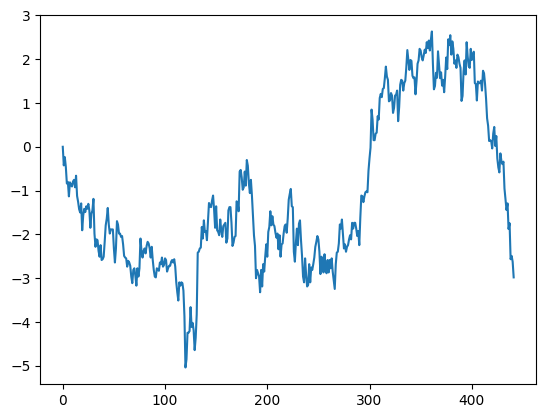

In [30]:
import matplotlib.pyplot as plt
plt.plot(equity_L)
equity